In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = '/content/Online Retail.xlsx'
df = pd.read_excel(file_path, sheet_name='Online Retail')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [7]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [8]:
clv_df = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (ref_date - x.max()).days, 'count'],
    'TotalAmount': ['sum', 'mean']
})
clv_df.columns = ['recency', 'frequency', 'monetary_total', 'aov']
clv_df = clv_df.reset_index()


In [9]:
X = clv_df[['recency', 'frequency', 'aov']]
y = clv_df['monetary_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 687.08
RMSE: 4300.21


In [12]:
clv_df['predicted_ltv'] = model.predict(X)
clv_df['segment'] = pd.qcut(clv_df['predicted_ltv'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


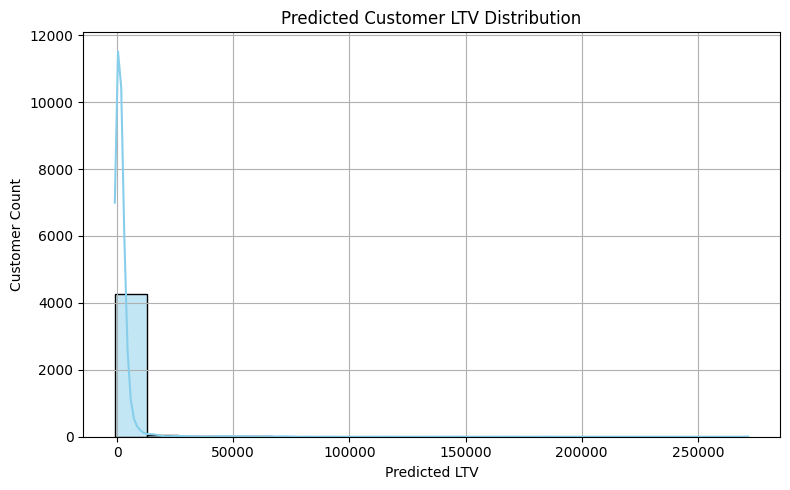

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(clv_df['predicted_ltv'], bins=20, kde=True, color='skyblue')
plt.title('Predicted Customer LTV Distribution')
plt.xlabel('Predicted LTV')
plt.ylabel('Customer Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
clv_df.to_csv('predicted_cltv_segments.csv', index=False)
print("Saved CSV: predicted_cltv_segments.csv")

Saved CSV: predicted_cltv_segments.csv


In [15]:
df.shape

(397884, 9)

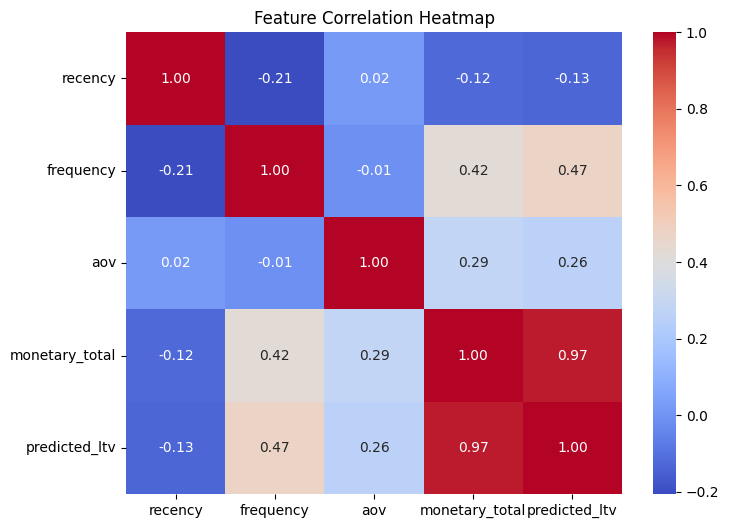

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(clv_df[['recency', 'frequency', 'aov', 'monetary_total', 'predicted_ltv']].corr(),
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [21]:
model.predict([[10,31,1000]])

array([9865.44], dtype=float32)